# CLV Calculation in Non-Contractual Business

This notebook is the first step in a deeper analysis of the [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) package.
The pre-cleaned data is transformed and CLV for the different customers is calculated.

#### Data Source
- `data/interim/clv_data.csv`: Cleaned data, prepared in first notebook.

#### Data Output
- `data/processed/ ...`: Cleaned version of the input data. Will later used as input for CLV calculations.

#### Changes
- 19-02-12: Start notebook

---

### Import libraries, load data

In [2]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *
from lifetimes import BetaGeoFitter

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(), sns.set_style('whitegrid')
%matplotlib inline  

# special settings for lifetime plots
sns.set_palette("viridis")
sns.set(rc={'image.cmap': 'viridis'})

import cleaning_functions as clean
import EDA_functions as EDA

# display of all columns in df
from IPython.display import display
pd.options.display.max_columns = None

In [57]:
# load data
clv_data = pd.read_csv('data/interim/clv_data.csv', parse_dates=['InvoiceDate'],
                       dtype={'CustomerID' : str, 'Country' : 'category'})

## 1) Prepare Data


In [58]:
clv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 6 columns):
Quantity       397884 non-null int64
InvoiceDate    397884 non-null datetime64[ns]
UnitPrice      397884 non-null float64
CustomerID     397884 non-null object
Country        397884 non-null category
Sales          397884 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 15.6+ MB


**Note:** For Lifetimes we need an Input Dataframe of transaction data of the form: 
- customer_id
- datetime 
- [monetary_value] (optional, but needed for clv estimations)

### Clean & Transform Data

In [59]:
"""transform data, to 'Lifetimes' format"""

clv_data.drop(['Quantity', 'UnitPrice', 'Country'], inplace=True, axis=1)
clv_data['InvoiceDate'] = clv_data['InvoiceDate'].dt.date
# use transformation function from liftimes package
clv = summary_data_from_transaction_data(clv_data, 
                                         customer_id_col='CustomerID', 
                                         datetime_col='InvoiceDate', 
                                         monetary_value_col='Sales')

In [60]:
# check results
print(clv.shape)
clv.head()

(4338, 4)


,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


**Nomenclature for the CLV model:**

- _Frequency_: represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. (Thus if they have made only 1 purchase, the recency is 0.)
- _T_: represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- _Recency_: represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

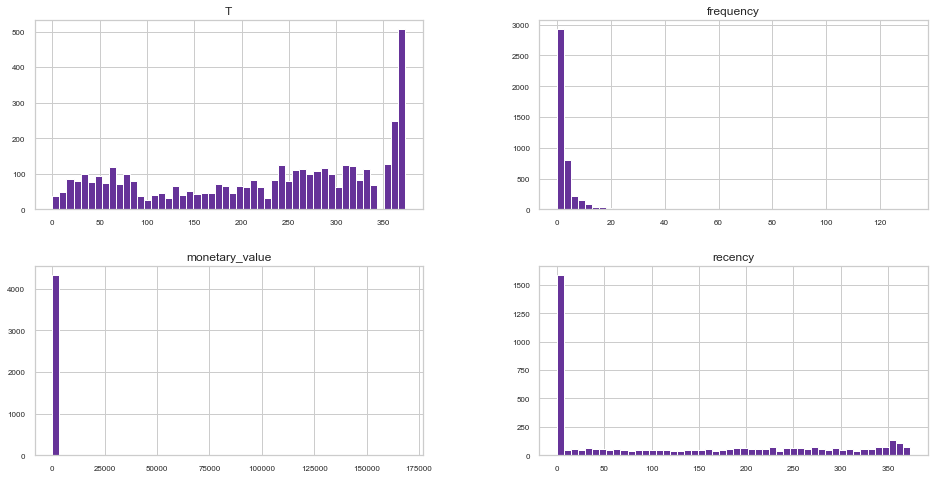

In [61]:
# check distributions - should be the same as in the EDA notebook (apart from monetary value)
EDA.plot_num_hist(clv, figsize=(16,8))

In [62]:
print("prop of customers without repeat purchase: ", round(clv['frequency'].value_counts()[0]/len(clv),3))

prop of customers without repeat purchase:  0.357


## 2) Forecast number of future purchases with BG / NBD model
The BG /NBD model allows us to compute the expected number of purchases in a forecast period at the customer level.

In [63]:
"""fit model with calibration and holdout sets"""

summary_cal_holdout = calibration_and_holdout_data(clv_data, 'CustomerID', 'InvoiceDate', 
                                                   monetary_value_col='Sales',
                                                   calibration_period_end='2011-06-09', # 9 months
                                                   observation_period_end='2011-12-09') # 4 months

In [64]:
# check results
display(summary_cal_holdout.head())

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,142.0,0.000000,0.0,0.000000,<183 * Days>
12347,3.0,184.0,184.0,498.053333,3.0,26.300625,<183 * Days>
12348,2.0,110.0,175.0,297.220000,1.0,103.333333,<183 * Days>
12350,0.0,0.0,127.0,0.000000,0.0,0.000000,<183 * Days>
12352,3.0,34.0,113.0,421.770000,3.0,20.090000,<183 * Days>


In [65]:
# 'repair' duration_holdout, set to float - should not happen according to docs ... ???
import re
summary_cal_holdout['duration_holdout'] = \
    summary_cal_holdout['duration_holdout'].astype(str)    
summary_cal_holdout['duration_holdout'] = \
    summary_cal_holdout['duration_holdout'].apply(lambda x: int(re.findall('\d+', x)[0]))

In [66]:
# check results
display(summary_cal_holdout.head())

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,142.0,0.000000,0.0,0.000000,183
12347,3.0,184.0,184.0,498.053333,3.0,26.300625,183
12348,2.0,110.0,175.0,297.220000,1.0,103.333333,183
12350,0.0,0.0,127.0,0.000000,0.0,0.000000,183
12352,3.0,34.0,113.0,421.770000,3.0,20.090000,183


In [67]:
# fit on the _cal columns, and test on the _holdout columns"""

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2800 subjects, a: 0.00, alpha: 61.20, b: 2.78, r: 0.74>

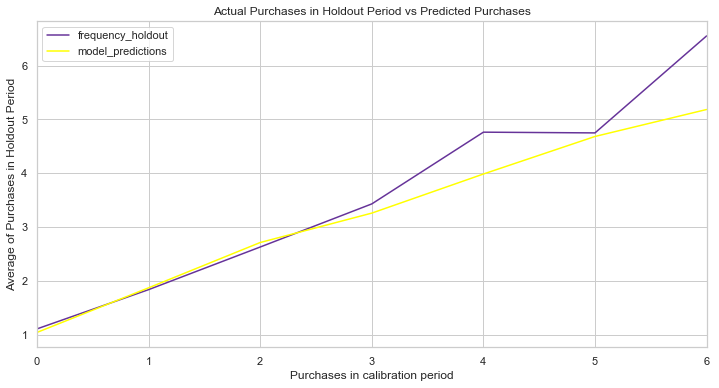

In [68]:
# plot results
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, figsize=(12,6),
                                                color=['rebeccapurple', 'yellow']);

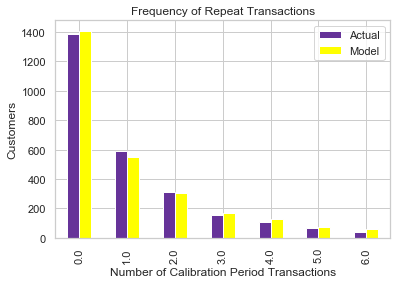

In [69]:
# assess model fit (with simulated data, cal_period only)
plot_period_transactions(bgf, color=['rebeccapurple', 'yellow']);

In [ ]:
break - show predictions for every customer

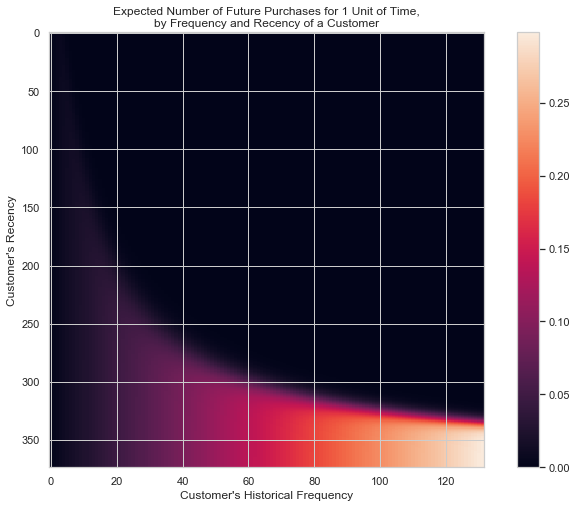

In [132]:
# plot frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf);

**Explanation:** Consider a customer bought from you every day for three weeks straight, and we haven’t heard from them in months. What are the chances they are still “alive”? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the Frequency/Recency matrix, which computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

- Our best customer is one that has made 250 purchases, and his latest purchase was when he was approximately 350 days old (bottom-right). Customers who have purchased a lot and purchased recently will likely be the best customers in the future. 
- Customers who have purchased a lot in the past but we have not heard them for long are the 'coldest', they have probably churned away (top-right corner).
- There’s also that beautiful “tail” around (40, 300). That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

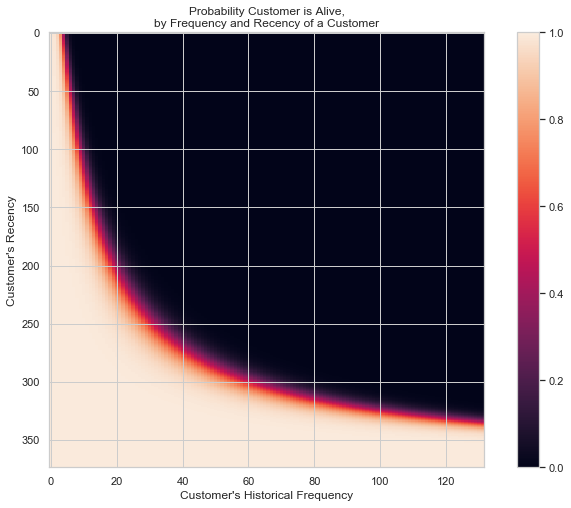

In [133]:
# plot probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf);

(**Technical Details:** The plot_probability_alive_matrix function computes P(alive) for all theoretical combinations of recency and frequency up to the maxima in your datasets given the parameters computed during the fit step. It assumes customer age, T to be equal to the maximum age of customers in your dataset.)

### Ranking customers from best to worst

Let’s rank our customers them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [135]:
t = 1  # setting number of periods for prediction
clv['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
    clv['frequency'], clv['recency'], clv['T'])

#check results
clv.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,probability_alive,predicted_purchases
CustomerID,,,,,,
14606,88.0,372.0,373.0,135.890114,0.999985,0.200980
15311,89.0,373.0,373.0,677.729438,0.999988,0.203244
17841,111.0,372.0,373.0,364.452162,0.999988,0.253021
12748,112.0,373.0,373.0,301.024821,0.999991,0.255284
14911,131.0,372.0,373.0,1093.661679,0.999989,0.298274


### Individual Customer Predictions
Based on customer history, we can predict what an individuals future purchases might look like.

In [78]:
t = 10 # predict purchases in 10 periods
individual = clv.loc['12347']
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15656764985792032

### Individual Customer Probability Histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model.

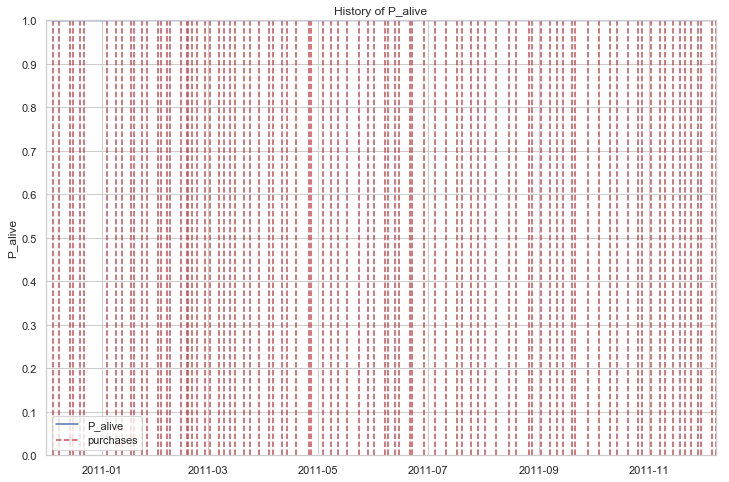

In [89]:
fig = plt.figure(figsize=(12,8))
id = '14606'
days_since_birth = 365
sp_trans = clv_data.loc[clv_data['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate');

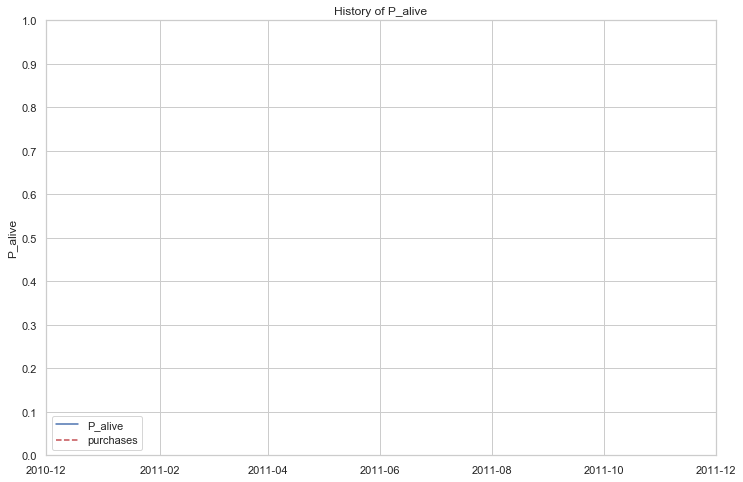

In [88]:
fig = plt.figure(figsize=(12,8))
id = '14729'
days_since_birth = 365
sp_trans = clv_data.loc[clv_data['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate');

### _Issue: Calculating P(alive) - unsolved_

If we calculate P(alive) with the bgf model, the probability score defaults to 1 for users that have no frequency (one-time purchasers). The Bruce Hardie paper that can be found in the `resources` states: _"We note that P(alive) = 1 for a customer who made no purchases in the interval (0, T]; this follows from the model’s assumptions that death occurs after a purchase and that customers are alive at the beginning of the observation period._

class BetaGeoFitter(). This model has the following assumptions:
1. Each individual, `i`, has a hidden `lambda_i` and `p_i` parameter
2. These come from a population wide Gamma and a Beta distribution respectively.
3. Individuals purchases follow a Poisson process with rate `lambda_i*t` .
4. After each purchase, an individual has a p_i probability of dieing (never buying again).

min: 0.82, max 1.0


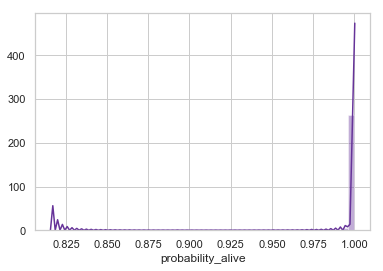

In [150]:
"""calculate the probabilities P(alive) for the customers"""

clv["probability_alive"] = bgf.conditional_probability_alive(clv["frequency"], 
                                                             clv ["recency"], clv ["T"])

# check results
print("min: {}, max {}".format(round(np.min(clv["probability_alive"]),2), \
np.max(clv["probability_alive"])))
sns.distplot(clv['probability_alive'], color='rebeccapurple');

**Not really working solution**

The [Modified Beta-Geometric model](https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/fitters/modified_beta_geo_fitter.py) should help. Details again in the paper and the issue [here](https://github.com/CamDavidsonPilon/lifetimes/issues/165). But it doesn't, at least without tuning.

class ModifiedBetaGeoFitter(BetaGeoFitter). This model has the following assumptions:
1. Each individual, ``i``, has a hidden ``lambda_i`` and ``p_i`` parameter
2. These come from a population wide Gamma and a Beta distribution respectively.
3. Individuals purchases follow a Poisson process with rate `\lambda_i*t` .
4. _At the beginning of their lifetime_ and after each purchase, an individual has a p_i probability of dieing (never buying again).

In [151]:
"""fit MBG model""" # note: similar API to scikit-learn and lifelines.

mbgf = ModifiedBetaGeoFitter(penalizer_coef=0.0)
mbgf.fit(clv['frequency'], clv['recency'], clv['T'])
print(mbgf)

<lifetimes.ModifiedBetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 69.05, b: 6.68, r: 0.83>


min: 0.9, max 0.9999911055210278


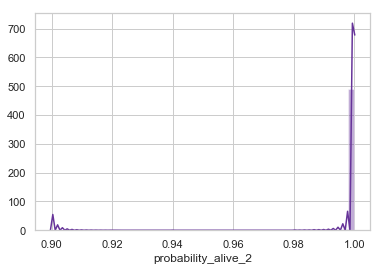

In [154]:
"""calculate the probabilities P(alive) for the customers"""

clv["probability_alive_2"] = mbgf.conditional_probability_alive(clv["frequency"], 
                                                             clv ["recency"], clv ["T"])

# check results
print("min: {}, max {}".format(round(np.min(clv["probability_alive_2"]),2), \
np.max(clv["probability_alive_2"])))
sns.distplot(clv['probability_alive_2'], color='rebeccapurple');

**Possible Solution (manually)**

Isn't it better to assume the average inter-purchase time as a baseline for assuming the first-time customers' probability of being alive? ...

### Assess model fit

There are a few ways to assess the model’s correctness. The first is to compare your data versus artificial data simulated with your fitted model’s parameters. We can see that our actual data and our simulated data line up well. This proves that our model doesn’t suck.

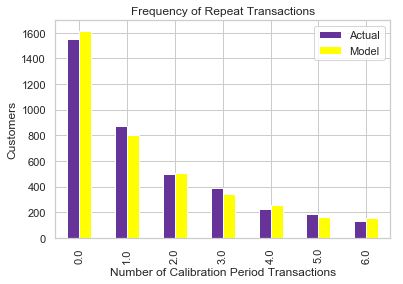

In [19]:
plot_period_transactions(bgf, color=['rebeccapurple', 'yellow']);

## Fit model with holdout set

With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:

In [20]:
"""fit model with calibration and holdout sets"""

summary_cal_holdout = calibration_and_holdout_data(clv_data, 'CustomerID', 'InvoiceDate', 
                                                   monetary_value_col='Sales',
                                                   calibration_period_end='2011-06-08',
                                                   observation_period_end='2011-12-9')   

---

## 3. Estimate customer lifetime value using the Gamma-Gamma model
Up to here we didn’t take into account the economic value of each transaction and focused mainly on transactions’ occurrences. 
To estimate the CLV we can use the [Gamma-Gamma submodel presented by Dr. Peter Fader and Dr. Bruce Hardie from Wharton](http://www.brucehardie.com/notes/025/gamma_gamma.pdf). For that we need to have summary data from transactional data that also contains economic values for each transaction (i.e. profits or revenues).

#### IMPORTANT: Fit only to returning customers (but you can predict for all)
_not yet sure if I won't run into the same issue as above with one-timers ..._

#### IMPORTANT: The Gamma-Gamma model and the independence assumption
The Gamma-Gamma submodelrelies upon an important assumption. _It assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model._

In [104]:
"""drop all one-time-only customers"""  # clv can only be calculated for returning customers

returning_customers = clv[clv['frequency']>0]

print(len(returning_customers))
display(returning_customers.head())

2790


,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12347,6.0,365.0,367.0,599.701667,0.015657
12348,3.0,283.0,358.0,301.480000,0.008958
12352,6.0,260.0,296.0,368.256667,0.018700
12356,2.0,303.0,325.0,269.905000,0.007172
12358,1.0,149.0,150.0,683.200000,0.008339


In [105]:
"""check for independence"""

print("pearson's r: ", round(np.corrcoef(returning_customers['monetary_value'], \
                                         returning_customers['frequency'])[0][1], 2))

pearson's r:  0.02


In [106]:
"""fit model"""

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.89>


### Estimate CLV
This method computes the average lifetime value for a group of one or more customers. It uses [DFC-Method](https://en.wikipedia.org/wiki/Discounted_cash_flow) adjusting for cost of capital and risk.

In [164]:
"""estimate CLV""" # can be predicted for all customers - at least in theory

# refit the BG model to the clv dataset (just for security, it is needed in clv function)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

clv_estimates = ggf.customer_lifetime_value(
    bgf, # the model to use to predict the number of future transactions, see above
    clv['frequency'],
    clv['recency'],
    clv['T'],
    clv['monetary_value'],
    time=12, # in months
    discount_rate=0.01) # monthly discount rate ~ 12.7% annually

# check results
clv_estimates.head()

CustomerID
12346     295.356775
12347    3011.934600
12348    1009.074856
12349    1337.166576
12350     307.043976
Name: clv, dtype: float64

Parameters:

- transaction_prediction_model: model
    the model to predict future transactions, literature uses
    pareto/ndb but we can also use a different model like bg

- frequency: array_like
    the frequency vector of customers' purchases
    (denoted x in literature).

- recency: the recency vector of customers' purchases
    (denoted t_x in literature).

- T: array_like
    customers' age (time units since first purchase)

- monetary_value: array_like
    the monetary value vector of customer's purchases
    (denoted m in literature).

- time: float, optional
    the lifetime expected for the user in months. Default: 12

- discount_rate: float, optional
    the monthly adjusted discount rate. Default: 0.01


Returns: Serries object with customer ids as index and the estimated customer
    lifetime values as values

### Estimate average transaction values

This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.

In [161]:
"""estimate avg monetary value for customers""" # can  be predicted for all customers - at least in theory

avg_value = ggf.conditional_expected_average_profit(clv['frequency'],
                                                    clv['monetary_value'])

# check resutls
avg_value.head()

CustomerID
12346    416.945993
12347    569.978843
12348    333.784213
12349    416.945993
12350    416.945993
dtype: float64

In [178]:
print("Expected conditional average value:", avg_value.mean()) # all customers
print("Observed average value:", returning_customers['monetary_value'].mean()) # returning only!

Expected conditional average value: 441.15943083233503
Observed average value: 477.3803385139518


---